**Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Load Data and Perform Preprocessing**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving winequality-white.csv to winequality-white.csv


In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['winequality-white.csv']), sep=';')


In [ ]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [ ]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [ ]:
print(df.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [ ]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

**Encode the Quality column again**

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

df['quality'] = OrdinalEncoder().fit_transform(df['quality'].to_numpy().reshape(-1,1))

In [ ]:
df['quality'].value_counts()

3.0    2198
2.0    1457
4.0     880
5.0     175
1.0     163
0.0      20
6.0       5
Name: quality, dtype: int64

### **Drop the unnecessary columns and split the dataset**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['quality','fixed acidity','volatile acidity','citric acid','residual sugar','free sulfur dioxide','total sulfur dioxide','pH','sulphates'])
, df['quality'], test_size=0.25, random_state=25)

In [ ]:
X_train

,chlorides,density,alcohol
2009,0.034,0.99350,12.2
4112,0.041,0.99078,11.1
3598,0.033,0.99043,12.3
1010,0.043,0.99320,10.3
4344,0.176,0.99288,9.2
...,...,...,...
1175,0.042,0.99650,9.1
255,0.040,0.99350,9.6
2934,0.028,0.99215,9.8
2191,0.037,0.99810,9.7


**Build the Multinomial model**

In [ ]:
model = sm.MNLogit(y_train, X_train)
results = model.fit()


print(results.summary())
print(results.summary2())

Optimization terminated successfully.
         Current function value: 1.163825
         Iterations 13
                          MNLogit Regression Results                          
Dep. Variable:                quality   No. Observations:                 3673
Model:                        MNLogit   Df Residuals:                     3655
Method:                           MLE   Df Model:                           12
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                 0.09892
Time:                        18:09:14   Log-Likelihood:                -4274.7
converged:                       True   LL-Null:                       -4744.0
Covariance Type:            nonrobust   LLR p-value:                2.958e-193
 quality=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
chlorides     -4.6994      7.347     -0.640      0.522     -19.099       9.701
density        2.9545      2

In [ ]:
y_hat = results.predict(X_test)
y_hat.head()

,0,1,2,3,4,5,6
2384,0.004319,0.033503,0.247651,0.498321,0.189011,0.027024,0.000171
3677,0.002903,0.019457,0.066287,0.457382,0.369075,0.083226,0.001671
2080,0.005006,0.039412,0.402370,0.444673,0.096602,0.011924,0.000012
2578,0.001667,0.011692,0.034332,0.343024,0.476027,0.109292,0.023965
401,0.004737,0.038909,0.560808,0.343987,0.046740,0.004817,0.000001


In [ ]:
predictions = y_hat.idxmax(axis=1)

Predictions    2    3   4
Actual                   
0.0            0    2   0
1.0           13   23   0
2.0          180  208   1
3.0          123  387  17
4.0           28  158  38
5.0            7   29   9
6.0            0    1   1


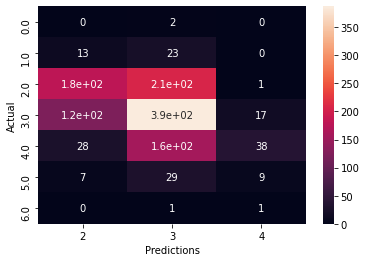

In [ ]:
conf_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predictions'])
print(conf_matrix)

sb.heatmap(conf_matrix, annot=True)
plt.show()

In [ ]:
from sklearn.metrics import (accuracy_score) 
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, predictions))

Test accuracy =  0.49387755102040815


### **Now I build models with all the input variables in the original dataset**

**1- Model considering all inputs and all classes**

In [ ]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(df.drop(columns=['quality'])
, df['quality'], test_size=0.25, random_state=20)

In [ ]:
X1_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
2731,7.9,0.51,0.36,6.2,0.051,30.0,173.0,0.99840,3.09,0.53,9.7
2550,6.2,0.33,0.14,4.8,0.052,27.0,128.0,0.99475,3.21,0.48,9.4
292,7.4,0.28,0.42,19.8,0.066,53.0,195.0,1.00000,2.96,0.44,9.1
1002,6.4,0.28,0.43,7.1,0.045,60.0,221.0,0.99520,3.09,0.45,9.4
367,6.9,0.33,0.21,1.0,0.053,39.0,148.0,0.99270,3.12,0.45,9.4


In [ ]:
model_1 = sm.MNLogit(y1_train, X1_train)
results = model_1.fit()


print(results.summary())
print(results.summary2())

Optimization terminated successfully.
         Current function value: 1.071862
         Iterations 13
                          MNLogit Regression Results                          
Dep. Variable:                quality   No. Observations:                 3673
Model:                        MNLogit   Df Residuals:                     3607
Method:                           MLE   Df Model:                           60
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                  0.1631
Time:                        18:11:27   Log-Likelihood:                -3936.9
converged:                       True   LL-Null:                       -4704.2
Covariance Type:            nonrobust   LLR p-value:                3.300e-281
           quality=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity           -0.6561      0.307     -2.139      0.032      -1.257      -0.05

In [ ]:
y_hat_1 = results.predict(X1_test)
y_hat_1.head()

,0,1,2,3,4,5,6
3994,0.000426,0.008978,0.133577,0.585713,0.226619,0.044620,0.000066
2540,0.007539,0.021842,0.248210,0.447923,0.232693,0.023357,0.018437
4030,0.000254,0.006693,0.110424,0.517742,0.323287,0.040867,0.000734
952,0.000224,0.037045,0.263316,0.516473,0.173157,0.009377,0.000407
1968,0.006035,0.018660,0.306480,0.498764,0.155909,0.013902,0.000249


In [ ]:
predictions_1 = y_hat_1.idxmax(axis=1)

Predictions  0  1    2    3   4
Actual                         
0.0          2  1    1    5   0
1.0          0  4   22   20   0
2.0          1  4  188  166   3
3.0          0  0  111  414  25
4.0          0  0    9  164  38
5.0          0  0    5   28  11
6.0          0  0    0    0   3


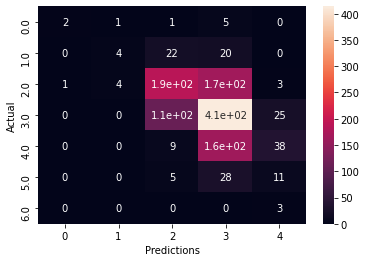

In [ ]:
conf_matrix = pd.crosstab(y1_test, predictions_1, rownames=['Actual'], colnames=['Predictions'])
print(conf_matrix)

sb.heatmap(conf_matrix, annot=True)
plt.show()

In [ ]:
from sklearn.metrics import (accuracy_score) 
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y1_test, predictions_1))

Test accuracy =  0.5273469387755102


### **Now I remove the quality class with the least data points and build two new models.**

**2- Model considering the removal of rows of quality class 6 (class with least data point)**

In [ ]:
df.drop(df[df['quality'] == 6].index, inplace = True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,3.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,3.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,3.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,3.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,3.0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,2.0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,3.0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,4.0


In [ ]:
from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(df.drop(columns=['quality'])
, df['quality'], test_size=0.25, random_state=20)

In [ ]:
model_2 = sm.MNLogit(y2_train, X2_train)
results = model_2.fit()


print(results.summary())
print(results.summary2())

Optimization terminated successfully.
         Current function value: 1.081659
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:                quality   No. Observations:                 3669
Model:                        MNLogit   Df Residuals:                     3614
Method:                           MLE   Df Model:                           50
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                  0.1593
Time:                        18:24:22   Log-Likelihood:                -3968.6
converged:                       True   LL-Null:                       -4720.4
Covariance Type:            nonrobust   LLR p-value:                5.471e-282
           quality=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity           -0.7043      0.263     -2.673      0.008      -1.221      -0.18

In [ ]:
y_hat_2 = results.predict(X2_test)
y_hat_2.head()

,0,1,2,3,4,5
4515,0.002087,0.005830,0.143417,0.534970,0.267946,0.045750
2544,0.002351,0.038848,0.275273,0.475831,0.183723,0.023974
4031,0.000663,0.103423,0.604043,0.275453,0.015107,0.001311
914,0.006941,0.210679,0.578690,0.179997,0.022083,0.001610
4428,0.005397,0.026680,0.177681,0.465815,0.251424,0.073003


In [ ]:
predictions_2 = y_hat_2.idxmax(axis=1)

Predictions  1    2    3   4  5
Actual                         
0.0          0    0    3   1  1
1.0          0   18   20   0  0
2.0          2  180  169   3  0
3.0          1  106  411  41  0
4.0          0    9  171  46  0
5.0          0    0   30  12  0


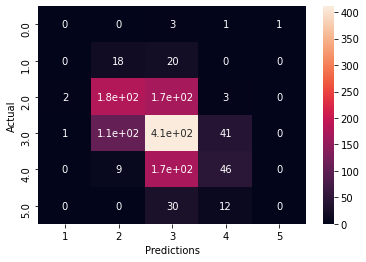

In [ ]:
conf_matrix = pd.crosstab(y2_test, predictions_2, rownames=['Actual'], colnames=['Predictions'])
print(conf_matrix)

sb.heatmap(conf_matrix, annot=True)
plt.show()

In [ ]:
from sklearn.metrics import (accuracy_score) 
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y2_test, predictions_2))

Test accuracy =  0.5204248366013072


**3- Model considering the removal of rows of quality class 6 and 0(two classes with least data point)**

In [ ]:
df.drop(df[df['quality'] == 6].index, inplace = True)
df.drop(df[df['quality'] == 0].index, inplace = True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,3.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,3.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,3.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,3.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,3.0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,2.0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,3.0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,4.0


In [ ]:
from sklearn.model_selection import train_test_split

X3_train, X3_test, y3_train, y3_test = train_test_split(df.drop(columns=['quality'])
, df['quality'], test_size=0.25, random_state=20)

In [ ]:
model_3 = sm.MNLogit(y3_train, X3_train)
results = model_3.fit()


print(results.summary())
print(results.summary2())

Optimization terminated successfully.
         Current function value: 1.056307
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                quality   No. Observations:                 3654
Model:                        MNLogit   Df Residuals:                     3610
Method:                           MLE   Df Model:                           40
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                  0.1629
Time:                        18:43:24   Log-Likelihood:                -3859.7
converged:                       True   LL-Null:                       -4610.6
Covariance Type:            nonrobust   LLR p-value:                2.857e-289
           quality=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity           -0.3565      0.117     -3.050      0.002      -0.586      -0.127

In [ ]:
y_hat_3 = results.predict(X3_test)
y_hat_3.head()

,0,1,2,3,4
4798,0.010495,0.226465,0.557493,0.171067,0.034481
2805,0.015126,0.181462,0.528029,0.242715,0.032668
1384,0.034972,0.120887,0.600522,0.225845,0.017773
312,0.035007,0.417929,0.422924,0.110513,0.013626
3577,0.007386,0.100979,0.551660,0.307663,0.032312


In [ ]:
predictions_3 = y_hat_3.idxmax(axis=1)

Predictions  0    1    2   3  4
Actual                         
1.0          1   25   15   1  0
2.0          0  185  168   3  0
3.0          1  106  420  29  1
4.0          0    9  154  56  0
5.0          0    6   28  11  0


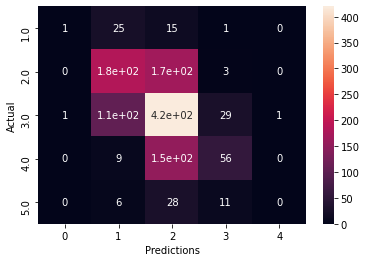

In [ ]:
conf_matrix = pd.crosstab(y3_test, predictions_3, rownames=['Actual'], colnames=['Predictions'])
print(conf_matrix)

sb.heatmap(conf_matrix, annot=True)
plt.show()

In [ ]:
from sklearn.metrics import (accuracy_score) 
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y3_test, predictions_3))

Test accuracy =  0.18211648892534865
